In [5]:
import urllib.request
import pandas as pd
import json

# 네이버에서 발급받은 클라이언트 ID와 시크릿 사용
client_id = "8u6CMnB5_BwZ3E2I46GE"
client_secret = "ZG6RF0J5JX"

# 파라미터 설정
display_count = 100   # 한 페이지에 표시할 검색 결과 수
num_data = 1000       # 검색할 데이터 개수
sort = "date"         # 정렬 기준 (date: 날짜순, sim: 유사도순)

# 검색할 단어와 URL 설정
encText = urllib.parse.quote("케이팝 데몬헌터스")

# 결과를 저장할 list 생성
results = []

# for문을 사용하여 검색 결과를 페이지별로 요청
for idx in range(1, num_data+1, display_count):
    
    # JSON 결과를 요청할 URL 생성
    url = "https://openapi.naver.com/v1/search/news?query=" + encText \
        + f"&start={idx}&display={display_count}&sort={sort}"
    
    # 요청 객체 생성
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    
    # 요청 보내서 응답 받기
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if(rescode == 200):   # 응답 코드가 200이면 성공
        # 응답 본문을 읽음
        response_body = response.read()
        # response_body는 바이너리이므로 decode를 통해 문자열로 변환
        response_dict = json.loads(response_body.decode('utf-8'))
        # dictionary에서 'items' 키를 사용하여 뉴스 기사 목록을 가져옴
        results += response_dict['items']
    else:
        print("Error Code:" + rescode)

# 데이터 개수 확인
print(f"총 데이터 개수: {len(results)}")

총 데이터 개수: 1000


In [6]:

from datetime import datetime
import re

# 저장할 빈 데이터프레임 생성
df = pd.DataFrame()

# 문자열에서 제거할 tag를 지정.
remove_tags = re.compile(r'<.*?>')   # HTML 태그 제거를 위한 정규표현식

# 검색 결과에서 필요한 정보 추출
for item in results:
    # 각 뉴스 기사에서 필요한 정보 추출
    new_data = pd.DataFrame(
        data={
            # 날짜는 datetime 객체로 변환
            'pubDate': datetime.strptime(item['pubDate'], "%a, %d %b %Y %H:%M:%S +0900"),
            # title과 description에서 HTML 태그 제거
            'title': re.sub(remove_tags, '', item['title']),
            'description': re.sub(remove_tags, '', item['description'])
        },
        index=[0]   # index를 0으로 설정하여 단일 행 데이터프레임 생성
    )

    # 데이터프레임에 추가
    df = pd.concat([df, new_data], ignore_index=True)

# CSV 파일로 저장
df.to_csv('kpop_demon_hunters_news.csv', index=False, encoding='utf-8')
print(f"데이터가 'kpop_demon_hunters_news.csv' 파일로 저장되었습니다.")

데이터가 'kpop_demon_hunters_news.csv' 파일로 저장되었습니다.


               pubDate                                              title  \
0  2025-12-15 13:08:00                 네이버, 7일간 '멤버십 특가전'…인기 가전 최대 55% 할인   
1  2025-12-15 12:58:00              네이버, 일주일간 'BIG 멤버십데이' 열고 '단골' 혜택 강화한다   
2  2025-12-15 12:48:00  배우 차학연, 日 팬미팅 'Channel A!' 성료! 뜨거운 환호 속 특별한 추억...   
3  2025-12-15 12:34:00                   국립고궁박물관, 올해 외국인 관람객 10명 중 3명..왜?   
4  2025-12-15 12:02:00   '케이스타뉴스룸' 신규진 &quot;최애=스테이씨·빅뱅 GD…GD 형처럼 롱런하고...   

                                         description  
0  넷플릭스 '케이팝 데몬 헌터스' 캐릭터 키링, 스포티파이 텀블러, Xbox기프트 카...  
1  네이버플러스 멤버십을 통해 디지털 콘텐츠를 즐기는 사용자들에게 다채로운 혜택을 제공...  
2  또한 '케이팝 데몬 헌터스' 속 사자보이즈의 '소다 팝' 댄스 커버 무대는 팬들의 ...  
3  케이팝 데몬 헌터스(케데헌)의 전세계적 열풍 등 영향을 받은 것으로 풀이된다. 15...  
4  이날 방송에서는 'K-POP 스타'를 주제로, 넷플릭스 애니메이션 '케이팝 데몬 헌...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pubDate      10

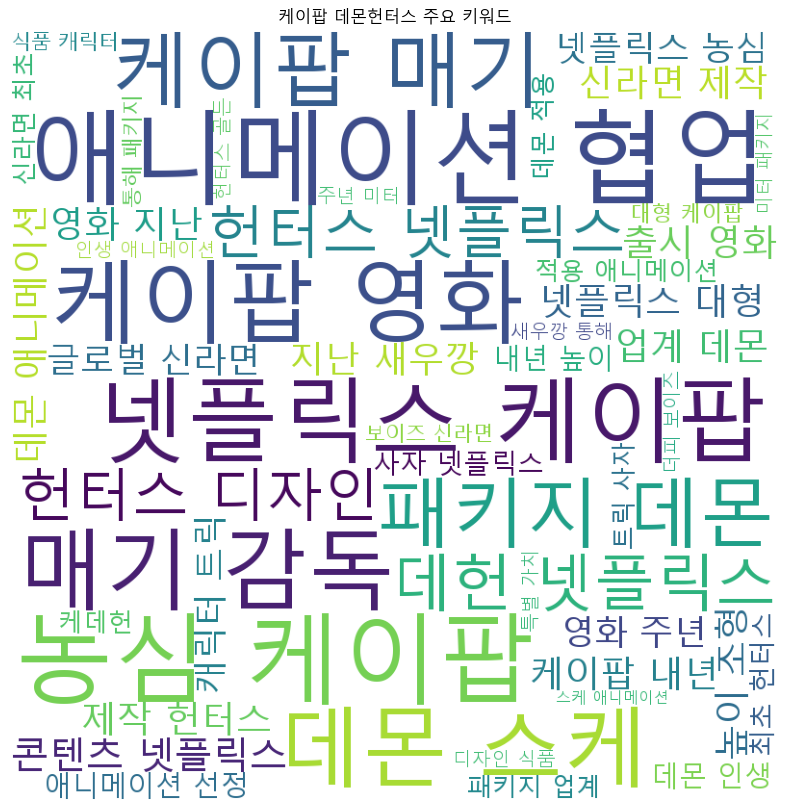

In [10]:
# 1. 데이터 로드 및 확인
import pandas as pd
df = pd.read_csv('kpop_demon_hunters_news.csv')
print(df.head())
print(df.info())

# 2. 텍스트 전처리 (강의록 3)
from konlpy.tag import Okt
import re

okt = Okt()

# 불용어 사전 불러오기 (강의록 4 방식)
with open('stop_str.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

# description 컬럼에서 명사 추출
all_nouns = []
for text in df['description'].tolist():
    # 한글과 공백만 남기기
    text_cleaned = re.sub(r'[^가-힣\s]', '', str(text))
    # 명사 추출
    nouns = okt.nouns(text_cleaned)
    # 한 글자 단어 및 불용어 제거 (강의록 3: set()으로 중복 제거)
    nouns = [word for word in set(nouns) if (len(word) > 1) and (word not in stopwords)]
    all_nouns.append(nouns)

# 3. 워드클라우드 생성 (강의록 3)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 한글 폰트 설정
han_font_path = 'C:\\Windows\\Fonts\\malgun.ttf'  # 맑은 고딕

# 모든 명사를 하나의 문자열로 합치기
text = ' '.join([word for nouns in all_nouns for word in nouns])

# 워드클라우드 생성
wc = WordCloud(
    font_path=han_font_path,
    max_words=50,
    width=800,
    height=800,
    background_color='white',
    colormap='viridis'
).generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis('off')
plt.title('케이팝 데몬헌터스 주요 키워드')
plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

[(('데몬', '케이팝'), 992), (('데몬', '헌터스'), 863), (('케이팝', '헌터스'), 863), (('넷플릭스', '케이팝'), 579), (('넷플릭스', '데몬'), 578), (('데몬', '애니메이션'), 536), (('애니메이션', '케이팝'), 536), (('넷플릭스', '헌터스'), 481), (('넷플릭스', '애니메이션'), 443), (('애니메이션', '헌터스'), 440)]
필터링된 엣지 개수: 1696
가장 가중치가 높은 edge 10개:
[(('데몬', '케이팝'), 992), (('데몬', '헌터스'), 863), (('케이팝', '헌터스'), 863), (('넷플릭스', '케이팝'), 579), (('넷플릭스', '데몬'), 578), (('데몬', '애니메이션'), 536), (('애니메이션', '케이팝'), 536), (('넷플릭스', '헌터스'), 481), (('넷플릭스', '애니메이션'), 443), (('애니메이션', '헌터스'), 440)]


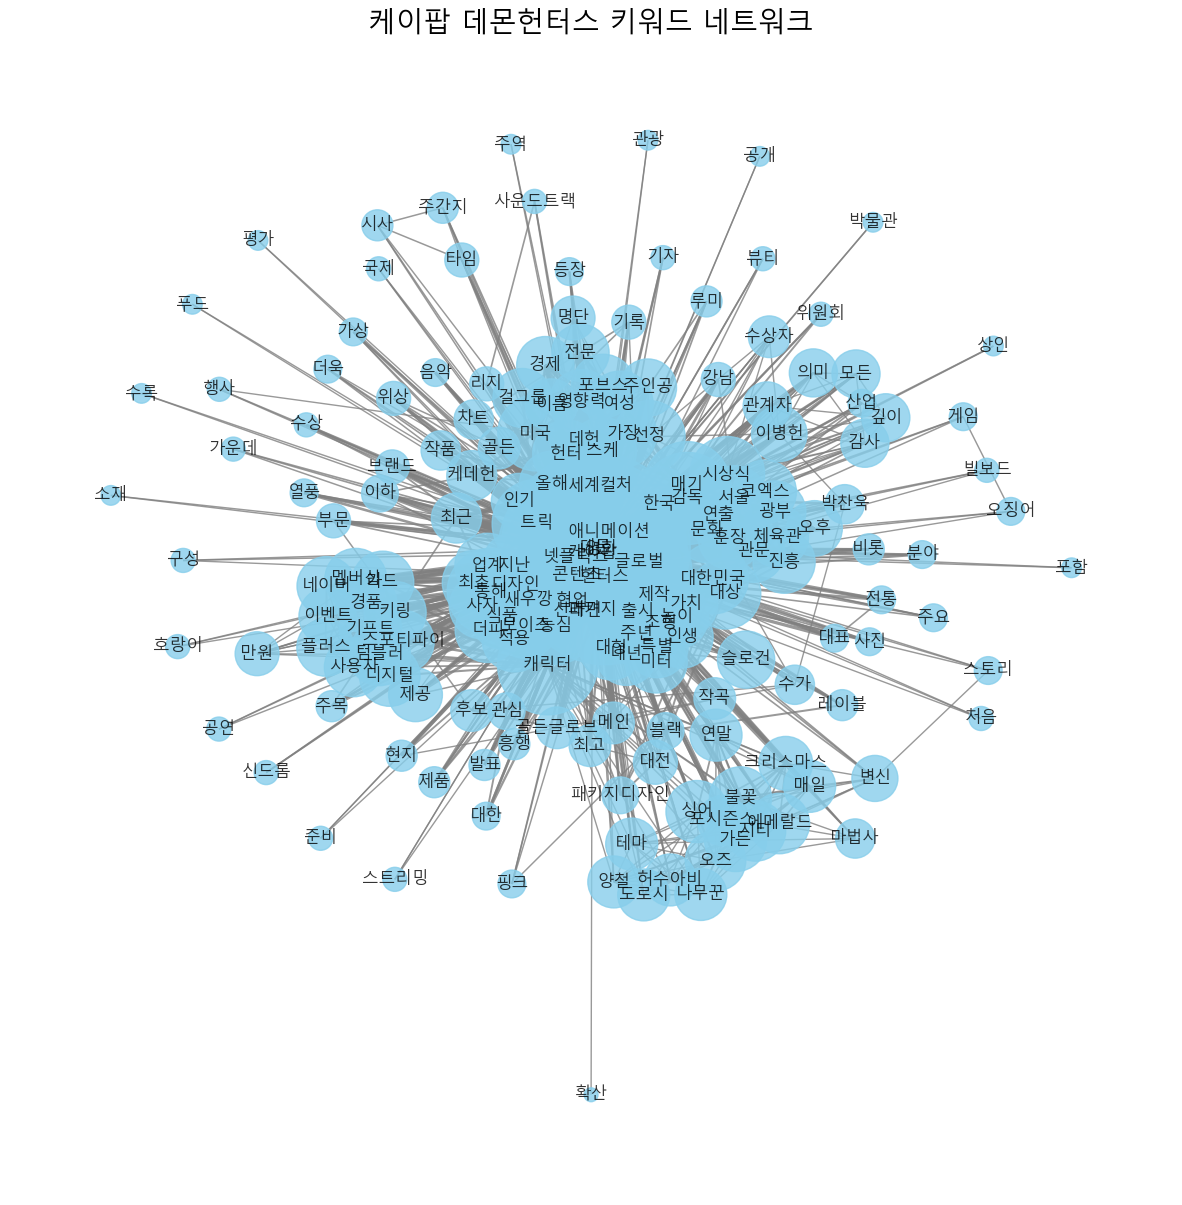

In [11]:
# 4. 네트워크 분석
from itertools import combinations
from collections import Counter
import networkx as nx

# edge 리스트 생성
edge_list = []

# 각 문서의 명사 목록에서 2-튜플 조합 생성
for nouns in all_nouns:
    if len(nouns) > 1:  # 단어가 2개 이상인 경우에만 처리
        # 사전순으로 정렬한 후 조합을 생성하여 edge_list에 추가
        edge_list.extend(combinations(sorted(nouns), 2))

# 생성된 edge 리스트의 중복 개수를 계산
edge_counts = Counter(edge_list)

# 가장 많이 등장한 10개의 엣지 출력
print(edge_counts.most_common(10))

# 지정된 최소 빈도 이상의 엣지만 필터링
min_count = 20
filtered_edges = {edge: weight for edge, weight in edge_counts.items() if weight >= min_count}

# 전체 edge 개수 출력
print(f'필터링된 엣지 개수: {len(filtered_edges)}')

# 가장 가중치가 높은 엣지 10개 출력
print(
    f'가장 가중치가 높은 edge 10개:\n'
    f'{sorted(filtered_edges.items(), key=lambda x: x[1], reverse=True)[:10]}'
)

# 그래프 객체 생성
G = nx.Graph()

# 가중치가 포함된 엣지 리스트 생성
weighted_edges = [
    (node1, node2, weight)
    for (node1, node2), weight in filtered_edges.items()
]

# 엣지와 가중치 추가
G.add_weighted_edges_from(weighted_edges)

# 레이아웃 생성
pos_spring = nx.spring_layout(
    G,
    k=0.3,        # 노드 간격 조절 파라미터
    iterations=50,# 반복 횟수
    seed=42
)

# 노드 크기 설정 (차수 기반)
node_sizes = [G.degree(node) * 100 for node in G.nodes()]

# 엣지 두께 설정 (가중치 기반)
edge_widths = [G[u][v]['weight'] * 0.05 for u, v in G.edges()]

# 그래프 그리기
plt.figure(figsize=(15, 15))
nx.draw_networkx(
    G,
    pos_spring,
    with_labels=True,
    node_size=node_sizes,
    width=edge_widths,
    font_family='Malgun Gothic',
    font_size=12,
    node_color='skyblue',
    edge_color='gray',
    alpha=0.8
)

plt.title('케이팝 데몬헌터스 키워드 네트워크', size=20)
plt.axis('off')
plt.savefig('network.png', format='PNG', dpi=300)
plt.show()

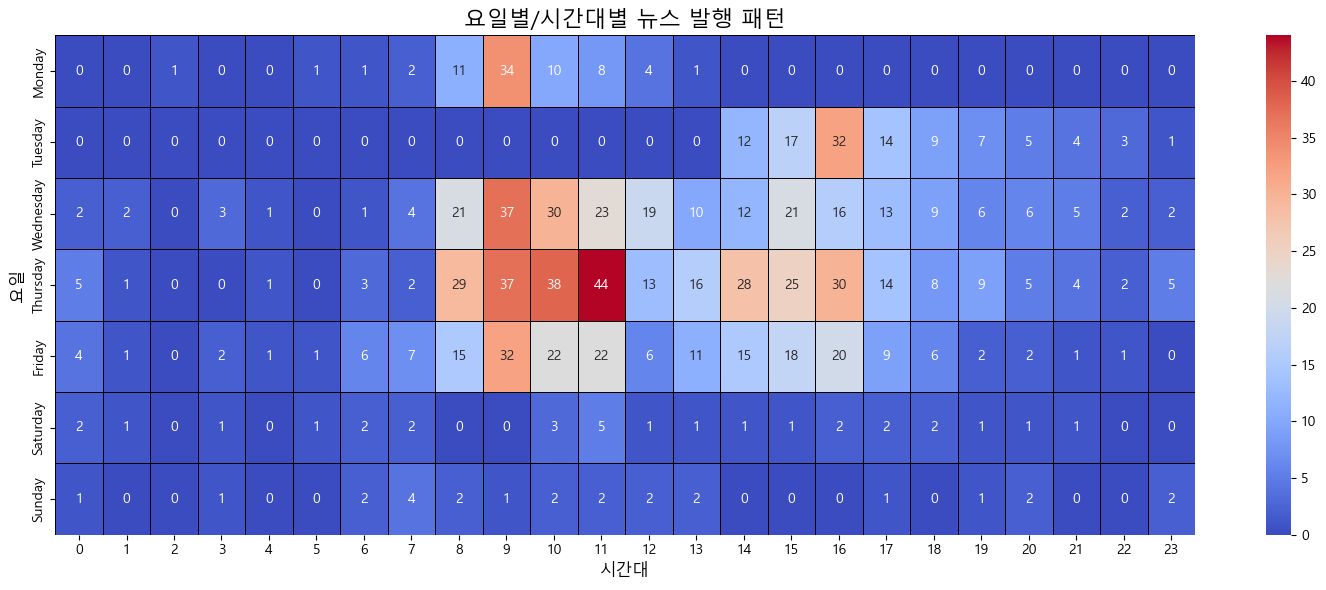

In [15]:
# 5. Seaborn - 요일별/시간대별 뉴스 발행 패턴 히트맵
import seaborn as sns
import numpy as np

# pubDate를 datetime으로 변환
df['pubDate'] = pd.to_datetime(df['pubDate'])

# 요일과 시간대 추출
df['day_of_week'] = df['pubDate'].dt.day_name()
df['hour'] = df['pubDate'].dt.hour

# 요일별/시간대별 기사 개수 집계
heatmap_data = df.groupby(['day_of_week', 'hour']).size().reset_index(name='count')
heatmap_pivot = heatmap_data.pivot(index='day_of_week', columns='hour', values='count').fillna(0)

# 요일 순서 정렬
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_pivot = heatmap_pivot.reindex(day_order)

# 히트맵 생성
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    data=heatmap_pivot,
    annot=True,
    cmap="coolwarm",
    fmt=".0f",
    linewidths=.5,
    linecolor='black',
    ax=ax
)
ax.set_title("요일별/시간대별 뉴스 발행 패턴", size=16)
ax.set_xlabel("시간대", size=12)
ax.set_ylabel("요일", size=12)
plt.tight_layout()
plt.savefig('heatmap_seaborn.png')
plt.show()

In [24]:
# 6. Altair - 키워드 빈도 Top 20 막대 그래프
import altair as alt

# 모든 명사를 하나의 리스트로 합치기 (이용오 교수님 텍스트마이닝 강의록 참고)
all_words = [word for nouns in all_nouns for word in nouns]

# 단어 빈도 계산
word_counts = Counter(all_words)
top_20 = word_counts.most_common(20)

# 데이터프레임 생성
df_keywords = pd.DataFrame(top_20, columns=['keyword', 'count'])

# 세로 막대 차트 생성
chart_vbar = alt.Chart(df_keywords).mark_bar().encode(
    x=alt.X('keyword:N', sort='-y', title='키워드'),
    y=alt.Y('count:Q', title='빈도수'),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='blues')),
    tooltip=['keyword', 'count']
).properties(
    height=400,
    width=600,
    title='상위 20개 키워드 빈도'
)

chart_vbar.show()
chart_vbar.save("barchart_altair.png")


alt.Chart(...)

In [29]:
# 7. Plotly - 날짜별 뉴스 개수 추이 라인 차트
import plotly.express as px

# 날짜별 기사 개수 집계
df['date'] = df['pubDate'].dt.date
date_counts = df.groupby('date').size().reset_index(name='count')

# 라인 차트 생성
fig = px.line(
    date_counts,
    x="date",
    y="count",
    markers=True,
    width=800, height=500,
    labels={'count': '기사 개수', 'date': '날짜'},
    title="날짜별 뉴스 기사 개수 추이"
)

fig.show()
